In [29]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime, os, urllib

"""
Instead of getting the data set manually in our browser we can adapt the URL to any coordinates that we want:
This was the original one:
    http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2018&task=0&place=Greenwich+%28UK%29&lon_sign=-1&lon_deg=0&lon_min=00&lat_sign=1&lat_deg=51&lat_min=28&tz=&tz_sign=-1
"""
year = 2018

# Label for place name: You don't need this but it will be in the saved local file:
label = "GreenwichUK" # Better not to use spaces or other special characters in this string! :) 
# Longitude West in Degrees and Minutes:
longitude = (0, 0)
# Latitude North in Degrees and Minutes:
latitude = (51, 28)


inFile = r'./%slocal.txt' % label

url = "http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2018&task=0&place=%s&lon_sign=-1&lon_deg=%s&lon_min=%s&lat_sign=1&lat_deg=%s&lat_min=%s&tz=&tz_sign=-1" % (label, longitude[0], longitude[1], latitude[0], latitude[1])
# Original:
##url = "http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2018&task=0&place=Greenwich+%28UK%29&lon_sign=-1&lon_deg=0&lon_min=00&lat_sign=1&lat_deg=51&lat_min=28&tz=&tz_sign=-1"

print "url:", url
# You can use urllib to retrieve the data but we would have to clean up some html tags to use it. 
# TODO: I will do this cleanup automatically later.
if not os.path.exists(inFile): # <----- !!!!
    print "Requested data file was not found locally. Fetching it from the interwebs..."
    urllib.urlretrieve (url, inFile)

    # Dirty and dumb way to get rid of the html and css before the data table:
    f = open(inFile, 'r')
    html=f.readlines()
    f.close()
    raw = html[25:66] # Slice only the lines that we need. 
        
    # Create/OverWrite the local file:
    with open(inFile, "w") as text_file:
        for line in raw:
            text_file.write(line)
    
    
else:
    print "Using local data file %s" % inFile
    

    


url: http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2018&task=0&place=GreenwichUK&lon_sign=-1&lon_deg=0&lon_min=0&lat_sign=1&lat_deg=51&lat_min=28&tz=&tz_sign=-1
Using local data file ./GreenwichUKlocal.txt


In [30]:
# The problem with loading this with np.loadtxt() is that there are a different numbe of columns when you get to the end of each month:
##A = np.loadtxt(inFile, skiprows=9) # Gives "ValueError: Wrong number of columns at line 38"

# (1)
# Let's try a pandas-based approach first:
##df = pd.read_csv(inFile, skiprows=range(7) + [7, 8], header=None, infer_datetime_format=True)
##print df
# This is currently a collection of rows, where each row is a long string. It has not split the row strings into columns yet:
##print df.shape

In [31]:
# (2)
# Let's try a different way:
##df = pd.read_csv(inFile, skiprows=range(7) + [7, 8], header=None, delim_whitespace=True, infer_datetime_format=True)
##print df
# This fails, because now February has 31 days! The columns are being shifted by the 

# This is currently a collection of rows, where each row is a long string. It has not split the row strings into columns yet:
##print df.shape

In [32]:
# (3)
# try pandas "fixed with" feature by spcifying colspec tuples that correspond to start and stop of columns. 

# This will choose the first and seconf columns according to their column numbers in the un-split text file:
eg = pd.read_fwf(inFile, colspecs=[(0,2), (4,8)], skiprows=9, header=None)

# We can loop over this for all months and we might as well split it into sunset and sunrise at the same time.
# This also makes it easier because the different months are separated by two spaces while the sunrise and sunset columns are separated by just one space. 
##sunrise = pd.read_fwf(inFile, colspecs=[(0,2)] + [(i, i+4) for i in range(4,132,11)], skiprows=9, header=None)
##sunset  = pd.read_fwf(inFile, colspecs=[(0,2)] + [(i, i+4) for i in range(9,137,11)], skiprows=9, header=None)
# Now without the day number:
sunrise = pd.read_fwf(inFile, colspecs=[(i, i+4) for i in range(4,132,11)], skiprows=9, header=None).values.T.flatten()
sunset  = pd.read_fwf(inFile, colspecs=[(i, i+4) for i in range(9,137,11)], skiprows=9, header=None).values.T.flatten()

# Remove all NaNs from the flattened lists to leave just the days that exist: https://stackoverflow.com/questions/11620914/removing-nan-values-from-an-array
sunrise = sunrise[~np.isnan(sunrise)].astype('int').tolist()
sunset = sunset[~np.isnan(sunset)].astype('int').tolist()

# Let's check what is happening by printing a sample:
print "Sunrise:\n", sunrise[:10], len(sunrise)
print "Sunset:\n", sunset[:10], len(sunset)

Sunrise:
[805, 805, 805, 805, 805, 804, 804, 803, 803, 802] 365
Sunset:
[1602, 1603, 1604, 1605, 1606, 1608, 1609, 1610, 1612, 1613] 365


In [33]:
"""
Now we want to convert our float values to datetimes.
We can do this using Python's datetime module but we will need to give it integer values for hours, minutes and seconds. 
"""
srise = [datetime.time(int(str(a)[:-2]), int(str(a)[-2:]), 0) for a in sunrise]
sset = [datetime.time(int(str(a)[:-2]), int(str(a)[-2:]), 0) for a in sunset]

print "srise:\n", srise[:10], len(srise)
print "sset:\n", sset[:10], len(sset)

srise:
[datetime.time(8, 5), datetime.time(8, 5), datetime.time(8, 5), datetime.time(8, 5), datetime.time(8, 5), datetime.time(8, 4), datetime.time(8, 4), datetime.time(8, 3), datetime.time(8, 3), datetime.time(8, 2)] 365
sset:
[datetime.time(16, 2), datetime.time(16, 3), datetime.time(16, 4), datetime.time(16, 5), datetime.time(16, 6), datetime.time(16, 8), datetime.time(16, 9), datetime.time(16, 10), datetime.time(16, 12), datetime.time(16, 13)] 365


In [34]:
# OK You might have noticed that the columns containing NaNs have been converted to floats while the months with 31 days are integers. 

# Creates a datetime list from any specific day:

# But we don't want the time, we want a "period":
periodlist = pd.date_range(start='%s-01-01' % year, end='%s-12-31' % year, freq='D')
print periodlist

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')


In [35]:
# Periodlist contains strings, so I will convert them to actual pandas datetime objects. This will make plotting easier: 
datelist = [pd.to_datetime(date, format='%m-%d').date() for date in periodlist]
print "Datelist:\n", datelist[:10]

Datelist:
[datetime.date(2018, 1, 1), datetime.date(2018, 1, 2), datetime.date(2018, 1, 3), datetime.date(2018, 1, 4), datetime.date(2018, 1, 5), datetime.date(2018, 1, 6), datetime.date(2018, 1, 7), datetime.date(2018, 1, 8), datetime.date(2018, 1, 9), datetime.date(2018, 1, 10)]


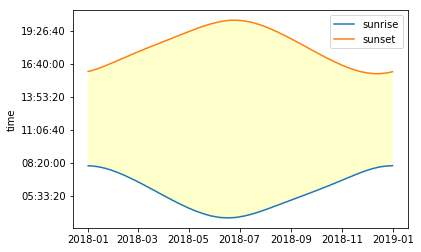

In [37]:
# Create a nice plot:
plt.close()
plt.figure()

# Plot the sunrise and sunset series as lineplots:
plt.plot(datelist, srise, label='sunrise')
plt.plot(datelist, sset, label='sunset')

# Let's put a fill between the two line plots:
plt.fill_between(datelist, srise, sset, facecolor='yellow', alpha=0.2, interpolate=True)

plt.legend()
plt.show()